In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from graph_construction import unpickle_graph, get_nodes_by_node_type, NodeType, get_downstream_columns, pickle_graph
from util import df_reader, df_reader_v2
import networkx as nx
import tqdm

from graph_analysis import get_gen_type_usage_df, show_gen_type_usage
from graph_analysis import col_to_dataset_analysis, analyze_cast_func_behavior, col_to_dp_analysis, ds_or_gp_to_gen_analysis, cross_type_cast_analysis, printTree

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from graph_analysis import get_cross_human_eval_results, get_dp_human_eval_results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [34]:
kaggle_g = unpickle_graph('assets/kaggle/kaggle_gen_graph.pickle')
harvard_g = unpickle_graph('assets/harvard/harvard_gen_graph.pickle')

In [35]:
"""
A T-FST can be directly connected to a G-FST, if there are no T-FSTs within the data-product that have the same name.
For consistency, we generate a dummy P-FST in between that is an exact copy of the T-FST.
"""
for g in [kaggle_g, harvard_g]:
    down_per_g = {}
    gen_types = get_nodes_by_node_type(g, NodeType.GENERAL_ENRICHED_SEMANTIC_TYPE)
    for gen_type in gen_types:
        down_per_g[gen_type] = get_downstream_columns(g, gen_type)
        
    for e in list(g.edges()):
        if (g.nodes[e[0]]['node_type'].value == NodeType.DATA_SET_SEMANTIC_TYPE.value) and (g.nodes[e[1]]['node_type'].value == NodeType.GENERAL_ENRICHED_SEMANTIC_TYPE.value):
            _, dp, _, c_name = e[0].split(':')
            p_name = f'TYPE:{dp}:*:{c_name}'
            g.add_node(
                p_name,
                node_type=NodeType.DATA_PRODUCT_SEMANTIC_TYPE,
                str_class_def=g.nodes[e[0]]['str_class_def'],
                obj_class_def=g.nodes[e[0]]['obj_class_def']
            )
            g.remove_edge(e[0], e[1])
            g.add_edge(e[0], p_name)
            g.add_edge(p_name, e[1])
            
    for gen_type in gen_types:
        assert get_downstream_columns(g, gen_type) == down_per_g[gen_type]

In [37]:
"""
Overall Graph Structure and Properties (Table 1) 
"""
macro_data = {}
for g, reader, name in tqdm.tqdm(zip([kaggle_g, harvard_g], [df_reader, df_reader_v2], ['kaggle', 'harvard'])):
    ds_nodes = get_nodes_by_node_type(g, NodeType.DATA_SET_SEMANTIC_TYPE)
    tables = set([g.nodes[n]['data_dir'] + '/' + g.nodes[n]['dp'] + '/' + g.nodes[n]['file_name'] + '.csv' for n in ds_nodes])
    dps = set([g.nodes[n]['dp'] for n in ds_nodes])
    
    num_cols_per_table = {}
    for table in tables:
        d = reader(table, max_rows=1)
        num_cols_per_table[table] = len(d.columns)
    
    total_num_cols = sum(num_cols_per_table.values())
    total_num_tables = len(tables)
    total_num_products = len(dps)
    total_num_anno_cols = len(get_nodes_by_node_type(g, NodeType.COLUMN))
    total_num_ds_types = len(ds_nodes)
    total_num_dp_types = len(get_nodes_by_node_type(g, NodeType.DATA_PRODUCT_SEMANTIC_TYPE))
    total_num_gen_types = len(get_nodes_by_node_type(g, NodeType.GENERAL_ENRICHED_SEMANTIC_TYPE))
    
    macro_data[name] = [total_num_cols, total_num_tables, total_num_products, total_num_anno_cols, total_num_ds_types, total_num_dp_types, total_num_gen_types]

2it [00:03,  1.66s/it]


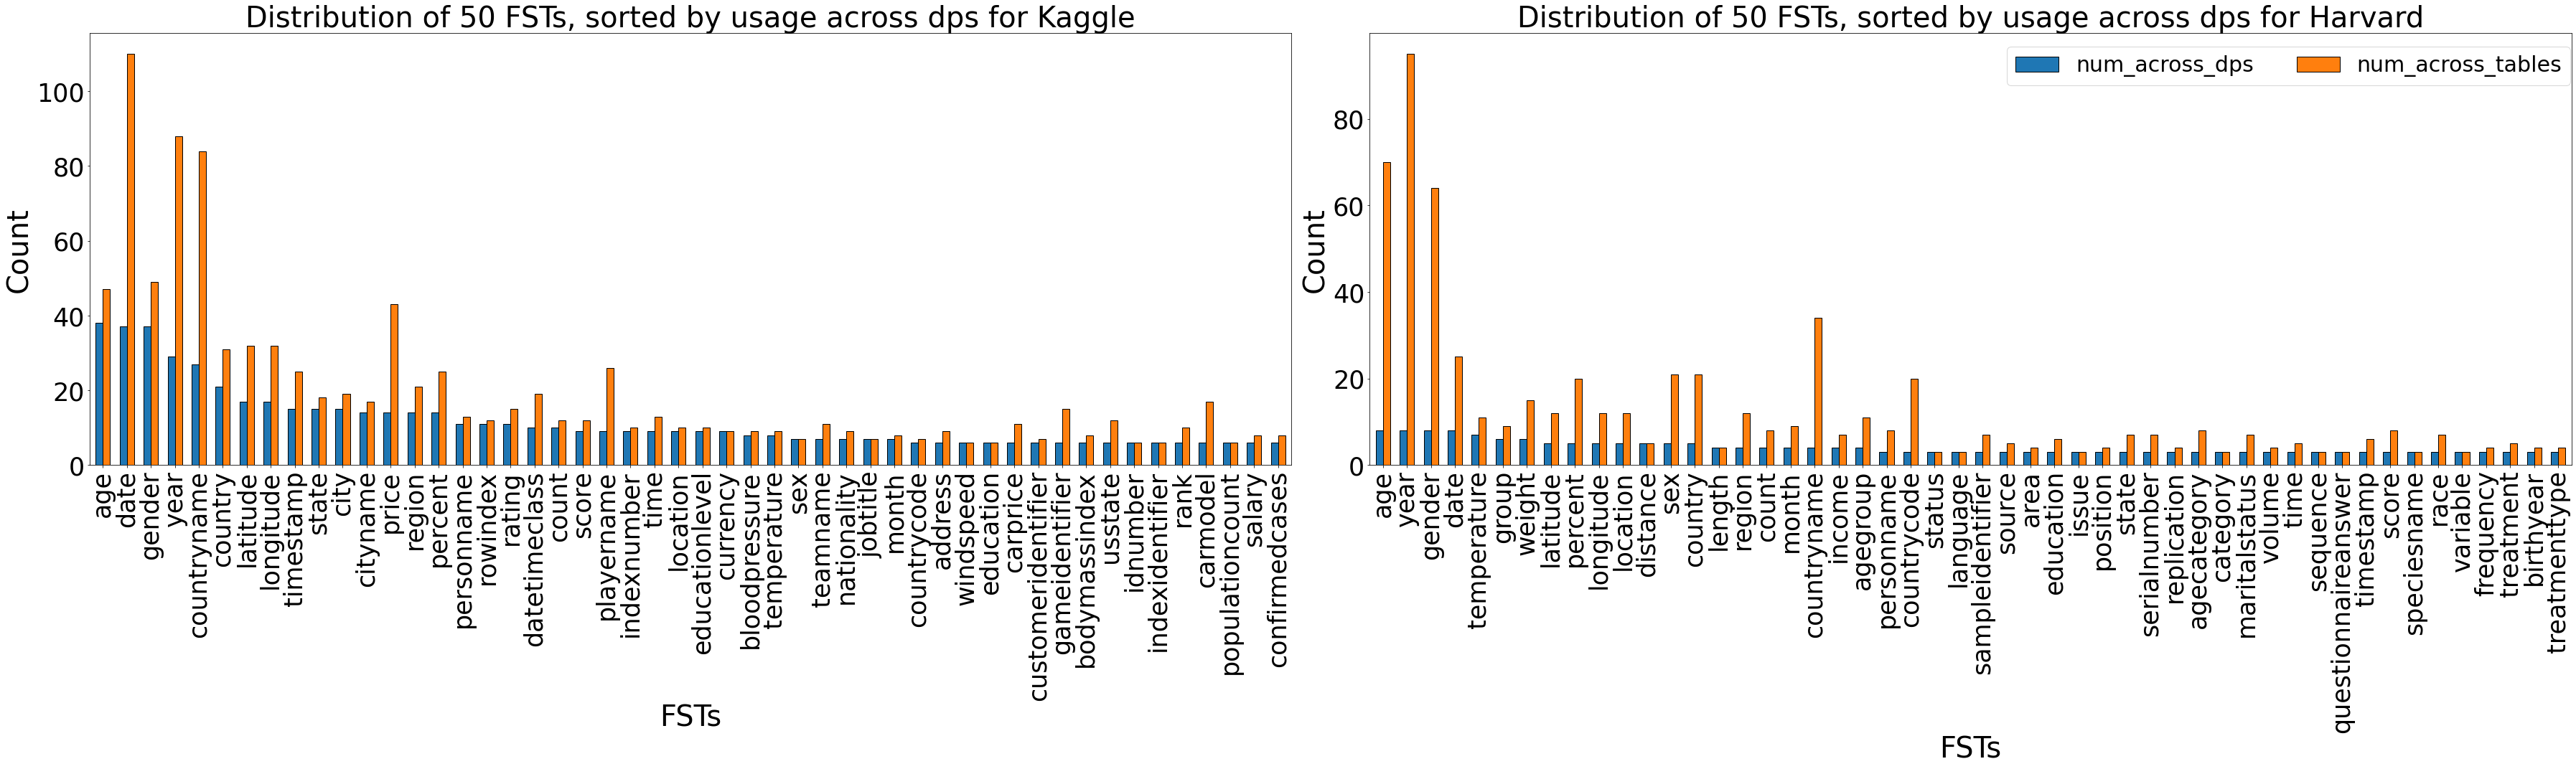

In [41]:
"""
Top 50 Most Used FSTs (Figure 7) 
"""
fig, axs = plt.subplots(1,2, figsize=(50, 15))

for ix, (g, name) in enumerate(zip([kaggle_g, harvard_g], ['kaggle', 'harvard'])):
    if ix == 2:
        continue
    ax = axs[ix]
    
    gen_type_usage_df = get_gen_type_usage_df(g)

    sub = gen_type_usage_df.loc[
        ~gen_type_usage_df.index.isin(['index', 'rowidentifier', 'uniqueidentifier', 'identifier', 'binaryvalue', 'surveydatawithnan', 'binaryresponse', 'rownumber'])
    ]
    sorted_df = sub.sort_values('num_across_dps', ascending=False)
    fontsize=35
    sorted_df[['num_across_dps', 'num_across_tables']].iloc[:50].plot.bar(
        ax=ax, fontsize=fontsize, width = 0.6, legend=False, edgecolor='black'
    )
    #ax.set_xticks(ax.get_xticks())
    ax.set_ylabel('Count', fontsize=40)
    ax.set_xlabel('FSTs', fontsize=40)
    ax.set_title(f'Distribution of 50 FSTs, sorted by usage across dps for {name.title()}', fontsize=40)
    
    
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, fontsize=30, bbox_to_anchor=(1, 0.95))
fig.tight_layout()

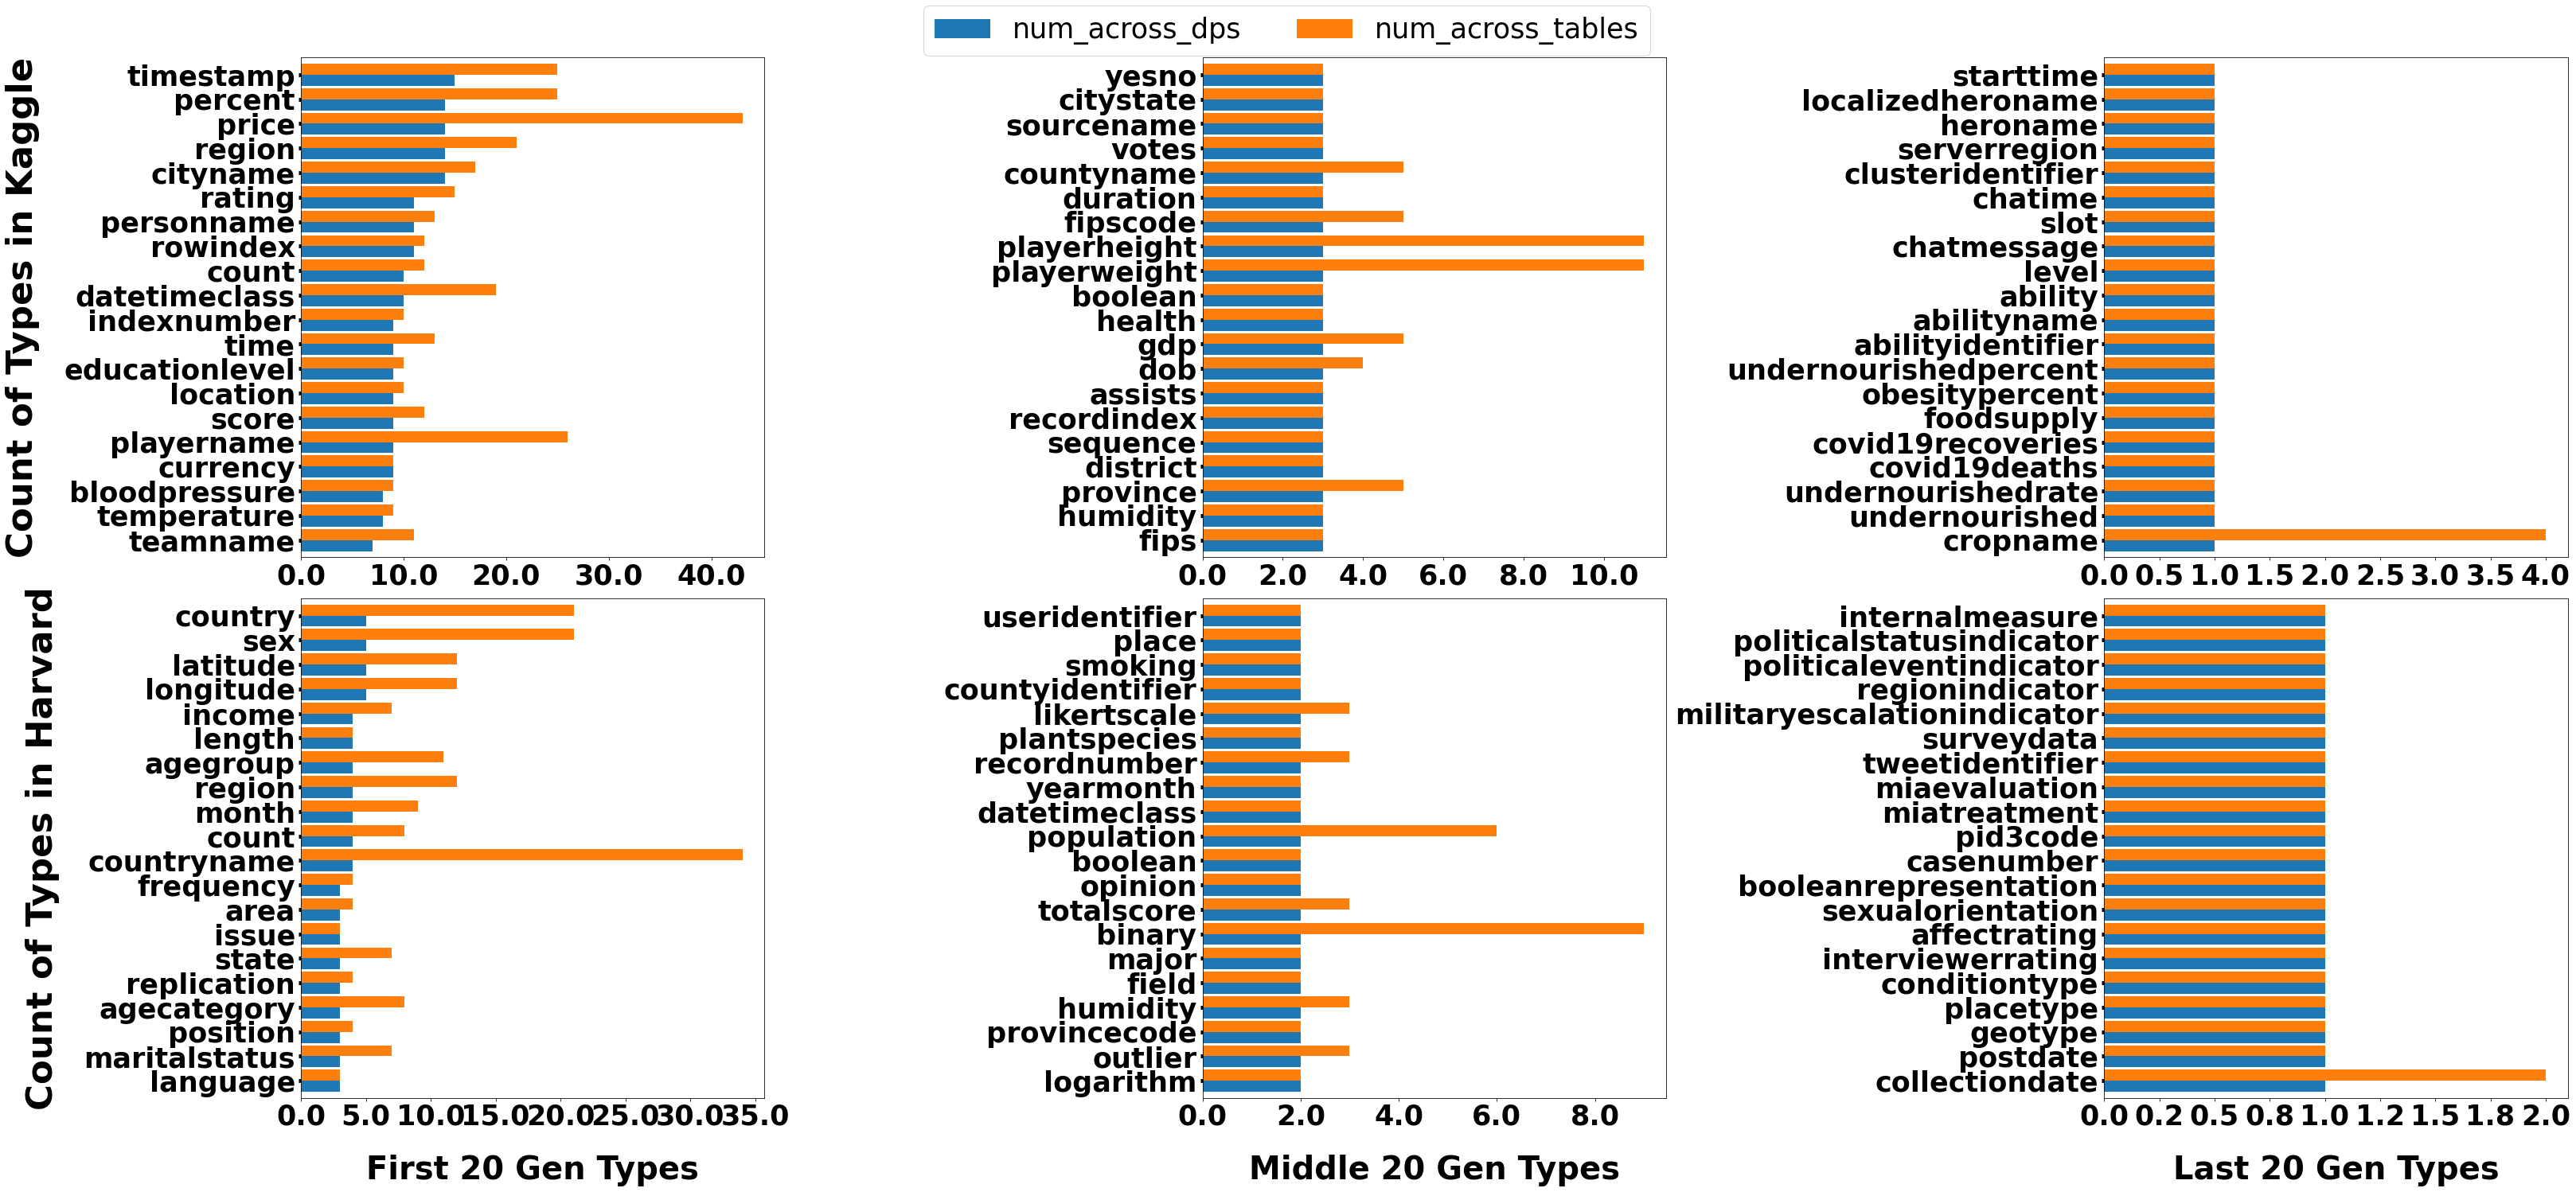

In [43]:
"""
Breakdown of Type Usage, for left, middle, and right chunks of the distribution. 
"""
def format_func(value, tick_number):
    return f'{value:0.1f}'

fig, axss = plt.subplots(2, 3, figsize=(45, 20))

for ix, (g, name) in enumerate(zip([kaggle_g, harvard_g], ['kaggle', 'harvard'])):
    axs = axss[ix]
    
    gen_type_usage_df = get_gen_type_usage_df(g)

    sub = gen_type_usage_df.loc[
        ~gen_type_usage_df.index.isin(['index', 'rowidentifier', 'uniqueidentifier', 'identifier', 'binaryvalue', 'surveydatawithnan'])
    ]
    sorted_df = sub.sort_values('num_across_dps', ascending=False)

    num_show = 20
    top_df = sorted_df.iloc[10:30]
    mid_df = sorted_df.iloc[100:100+num_show]
    end_df = sorted_df.iloc[-num_show:]

    fontsize=35
    top_df[['num_across_dps', 'num_across_tables']].iloc[::-1].plot.barh(ax=axs[0], fontsize=fontsize, width = 0.9, legend=False)
    mid_df[['num_across_dps', 'num_across_tables']].iloc[::-1].plot.barh(ax=axs[1], fontsize=fontsize, width = 0.9, legend=False)
    end_df[['num_across_dps', 'num_across_tables']].iloc[::-1].plot.barh(ax=axs[2], fontsize=fontsize, width = 0.9, legend=False)
    
    if ix == 1:
        axs[0].set_xlabel(f'First {num_show} Gen Types', weight='bold', fontsize=fontsize + 5, labelpad=30)
        axs[1].set_xlabel(f'Middle {num_show} Gen Types', weight='bold', fontsize=fontsize + 5, labelpad=30)
        axs[2].set_xlabel(f'Last {num_show} Gen Types', weight='bold', fontsize=fontsize + 5, labelpad=30)
        
    axs[0].set_ylabel(f'Count of Types in {name.title()}', weight='bold', fontsize=fontsize + 10, labelpad=30)
        
    for ax in axs:
        for label in ax.get_xticklabels():
            label.set_weight('bold')

        for label in ax.get_yticklabels():
            label.set_weight('bold')

    for ax in axs:
        ax.tick_params(axis='y', which='major', width=5)
        ax.xaxis.set_major_formatter(FuncFormatter(format_func))
        
    
fig.tight_layout()
handles, labels = axss[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=fontsize, bbox_to_anchor=(0.5, 1.05))

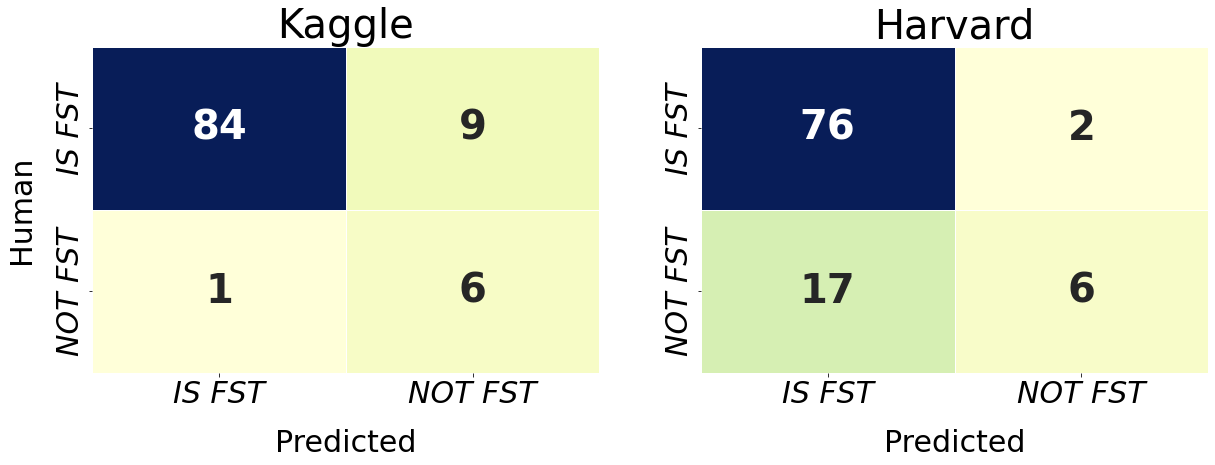

In [76]:
"""
Confusion Matrices that show true positive (TP), false positive (FP), true negative (FN), and false negative
(FN) for Generated P-FSTs (Figure 4)
"""
readers = [
    df_reader,
    df_reader_v2,
]

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
labels = ['IS FST', 'NOT FST']
all_correct = []
for ix, (src_dir, g, reader, name) in enumerate(zip(dirs, [kaggle_g, harvard_g], readers, ['kaggle', 'harvard'])):
    dp_human_df = pd.read_csv(f'assets/{name}/{name}_pfst_human_eval.csv')

    if len(dp_human_df) == 0:
        continue
    
    correctness_of_positives = dp_human_df.loc[
        (dp_human_df.human_prediction == dp_human_df.gpt_prediction) & (dp_human_df.human_prediction == 'IS FST')
    ].groupby('scope')['unique_id'].count()
    
    all_correct.append(correctness_of_positives.to_frame().T.rename({'unique_id': name}))
    
    confuse_mat = confusion_matrix(
        dp_human_df[['human_prediction']], dp_human_df[['gpt_prediction']],
        labels=labels,
        normalize='all'
    )
    sns.heatmap(
        np.round(confuse_mat*100).astype(int), ax=axs[ix], annot=True, fmt="d", linewidths=.5, cbar= False,
        cmap="YlGnBu", annot_kws={"size": 40, 'weight':'bold'},
    )

    axs[ix].set_title(name.title(), fontsize=40)
    if ix == 0:
        axs[ix].set_ylabel('Human', fontsize=30, labelpad=20)
    axs[ix].set_xlabel('Predicted', fontsize=30, labelpad=20)
    axs[ix].set_xticklabels(labels, rotation=0, fontsize=30, style='italic')
    axs[ix].set_yticklabels(labels, rotation=90, fontsize=30,va='center', style='italic')
    
for ax in axs:
    ax.yaxis.set_tick_params(which='both', labelbottom=True)
    #disp.plot(ax=axs[ix])


In [77]:
"""
Correction Breakdown of P-FSTs (Table 5)
"""
correctness_of_dp_types = pd.concat(all_correct).fillna(0)[['Too Broad', 'Too Specific', 'Totally Incorrect', 'Slightly Wrong', 'Just Right']]
correctness_of_dp_types

scope,Too Broad,Too Specific,Totally Incorrect,Slightly Wrong,Just Right
kaggle,61,6,11,20,297
harvard,40,2,3,1,182


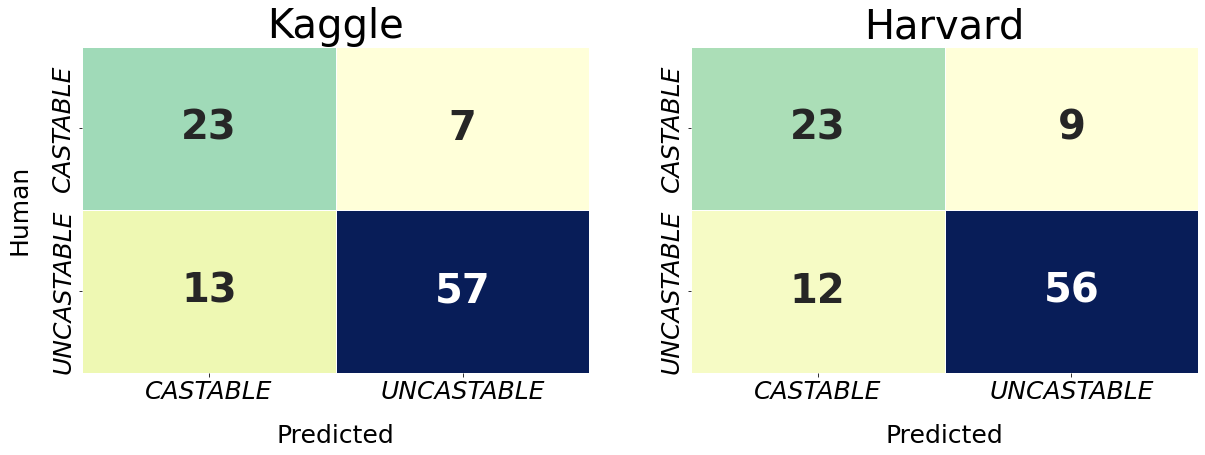

In [82]:
"""
Correction Breakdown of Cross Type Casts (Figure 5)
"""
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
labels = ['CASTABLE', 'UNCASTABLE']
all_correct = []
temp = {}
for ix, (src_dir, g, name) in enumerate(zip(dirs, [kaggle_g, harvard_g], ['kaggle', 'harvard'])):
    cross_df = pd.read_csv(f'assets/{name}/{name}_crosstypecast_human_eval.csv')
    if len(cross_df) == 0:
        continue
    direct_cross_df = cross_df.loc[cross_df.edge_type == 'direct']
    
    
    features = direct_cross_df.loc[
        (direct_cross_df.human_prediction == direct_cross_df.gpt_prediction) & (direct_cross_df.gpt_prediction == 'CASTABLE')
    ][['identical', 'reasoning', 'logic']]
    
    all_correct.append(
        (features.sum()*100/len(features)).round(2).to_frame().T.rename({0: name})
    )
    
    confuse_mat = confusion_matrix(
        direct_cross_df[['human_prediction']], direct_cross_df[['gpt_prediction']],
        labels=labels,
        normalize='all'
    )
    
    sns.heatmap(
        np.round(confuse_mat*100).astype(int), ax=axs[ix], annot=True, fmt="d", linewidths=.5, cbar= False,
        cmap="YlGnBu", annot_kws={"size": 40, 'weight':'bold'},
    )

    axs[ix].set_title(name.title(), fontsize=40)
    if ix == 0:
        axs[ix].set_ylabel('Human', fontsize=25, labelpad=20)
    axs[ix].set_xlabel('Predicted', fontsize=25, labelpad=20)
    axs[ix].set_xticklabels(labels, rotation=0, fontsize=25, style='italic')
    axs[ix].set_yticklabels(labels, rotation=90, fontsize=25,va='center', style='italic')
    
for ax in axs:
    ax.yaxis.set_tick_params(which='both', labelbottom=True)
    #disp.plot(ax=axs[ix])

In [55]:
"""
Correctness of the Cross Type Casts
"""
correctness_of_cc_funcs = pd.concat(all_correct)
correctness_of_cc_funcs

,identical,reasoning,logic
kaggle,67.81,87.67,79.45
harvard,47.83,72.83,68.48


In [ ]:
"""
Builds a Dictionary of Col -> P-FST Throughput Results
"""
per_g_dp_results = {}
for g, name in zip([kaggle_g, harvard_g], ['kaggle', 'harvard']):
    print(name)
    col_to_ds_results_df = col_to_dataset_analysis(g)
    col_to_dp_results_df = col_to_dp_analysis(g, col_to_ds_results_df)
    per_g_dp_results[name] = [col_to_ds_results_df, col_to_dp_results_df]

In [60]:
dp_list = []
for name, items in per_g_dp_results.items():
    dp_results = items[1]
    grouped = dp_results.groupby(['input_val_is_null', 'passed', 'changed'])['unique_id'].count()

    dp_list.append((grouped*100/grouped.sum()).to_frame().round(2))

In [61]:
"""
Col -> P-FST Results in Table 2
"""
dp_df = pd.concat(dp_list, axis=1).sort_index(ascending=False)
dp_df.columns = ['Kaggle', 'Harvard']
dp_df

Kaggle  Harvard
input_val_is_null passed changed                 
True              True   True      12.12    14.72
                  False  False      1.62     9.76
False             True   True      17.14    19.97
                         False     68.26    54.25
                  False  False      0.86     1.30

In [ ]:
"""
Builds a Dictionary of P-FST -> G-FST Throughput Results
"""
per_g_gen_results = {}
for g, name in zip([kaggle_g, harvard_g], ['kaggle', 'harvard']):
    gen_type_df = ds_or_gp_to_gen_analysis(g, *per_g_dp_results[name])
    per_g_gen_results[name] = gen_type_df

In [63]:
gen_list = []
for name, gen_results in per_g_gen_results.items():
    grouped = gen_results.groupby(['input_val_is_null', 'passed', 'changed', 'validated'])['unique_id'].count()

    gen_list.append((grouped*100/grouped.sum()).to_frame().round(2))

In [64]:
"""
P-FST -> G-FST Results in Table 3
"""
gen_df = pd.concat(gen_list, axis=1).sort_index(ascending=False)
gen_df.columns = ['Kaggle', 'Harvard']
gen_df

Kaggle  Harvard
input_val_is_null passed changed validated                 
True              True   True    True         0.04     0.28
                                 False        0.88     0.15
                         False   True         0.00      NaN
                                 False        0.00     0.00
                  False  False   False        0.00     0.00
False             True   True    True        11.59     7.02
                                 False        2.14     2.08
                         False   True        79.86    84.96
                                 False        2.61     4.12
                  False  False   False        2.87     1.38

In [ ]:
"""
Builds a Dictionary of G-FST -> G-FST Throughput Results
"""
per_cross_cast_results = {}
for g, name in zip([kaggle_g, harvard_g], ['kaggle', 'harvard']):
    cross_df = cross_type_cast_analysis(g, per_g_gen_results[name])
    per_cross_cast_results[name] = cross_df

In [67]:
cross_list = []
for name, cast_results in per_cross_cast_results.items():
    grouped = cast_results.groupby(['input_val_is_null', 'passed', 'changed', 'validated'])['unique_id'].count()

    cross_list.append((grouped*100/grouped.sum()).to_frame().fillna(0).round(2))

In [68]:
"""
G-FST -> G-FST Throughput Results (Table 4)
"""
cross_df = pd.concat(cross_list, axis=1).sort_index(ascending=False)
cross_df.columns = ['Kaggle', 'Harvard']
cross_df

Kaggle  Harvard
input_val_is_null passed changed validated                 
True              True   True    True         0.00     0.22
                                 False        0.00     0.40
                         False   True         0.00     0.00
                                 False        0.00     0.05
                  False  False   False        0.04     0.00
False             True   True    True        14.26    18.34
                                 False        0.95     2.30
                         False   True        77.30    63.55
                                 False        7.16    14.68
                  False  False   False        0.29     0.45

In [69]:
pickle.dump([per_g_dp_results, per_g_gen_results, per_cross_cast_results], open('assets/paper_raw_results.pickle', 'wb'))